In [4]:
# Calculate different clustering methods
import networkx as nx
import pandas as pd
from networkx.algorithms.centrality import edge_betweenness_centrality

G = nx.read_graphml("network.graphml")
threshold = 0.29

# Create a filtered graph
filtered_edges = [(u, v, d) for u, v, d in G.edges(data=True) if d['weight'] > threshold]

network = nx.Graph()
network.add_edges_from(filtered_edges)

# Clustering analysis


In [5]:

from collections import defaultdict

# Get different clustering partitions
louvain_communities = nx.community.louvain_communities(network)
label_propagation = nx.community.label_propagation_communities(network)
greedy_modularity = nx.community.greedy_modularity_communities(network)
girvan_newman = nx.community.girvan_newman(network)
#edge_betweenness_centrality = nx.community.edge_betweenness_centrality(network, 3)



# Create a dictionary to store clusters and their nodes
clustering_results = {
    'louvain': list(louvain_communities),
    'label_propagation': list(label_propagation),
    'greedy_modularity': list(greedy_modularity),
    "greedy_modularity": list(greedy_modularity),
    #"girvan_newman": list(girvan_newman),
    #"edge_betweenness_centrality": edge_betweenness_centrality
}



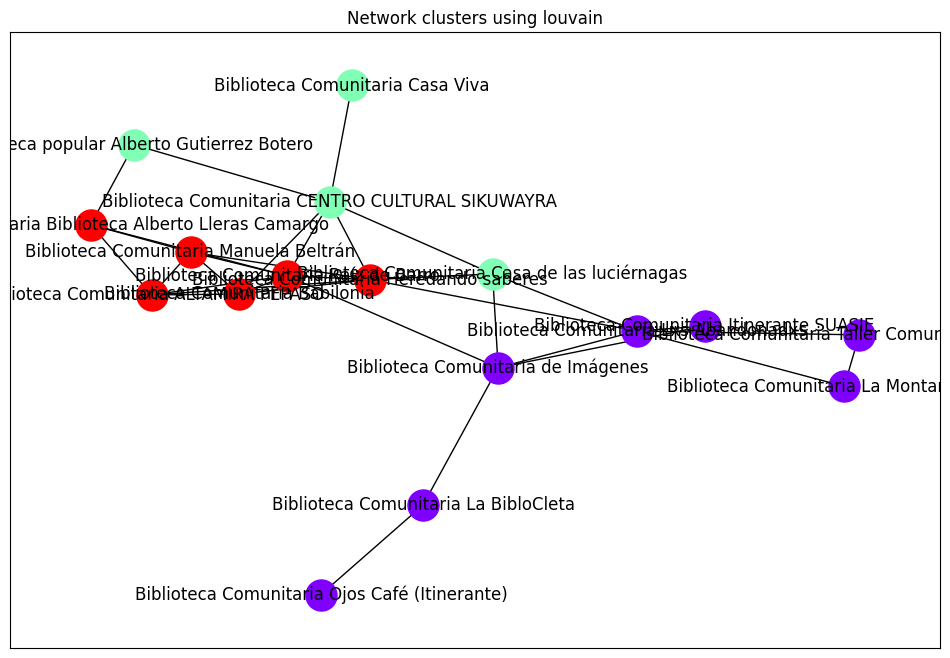

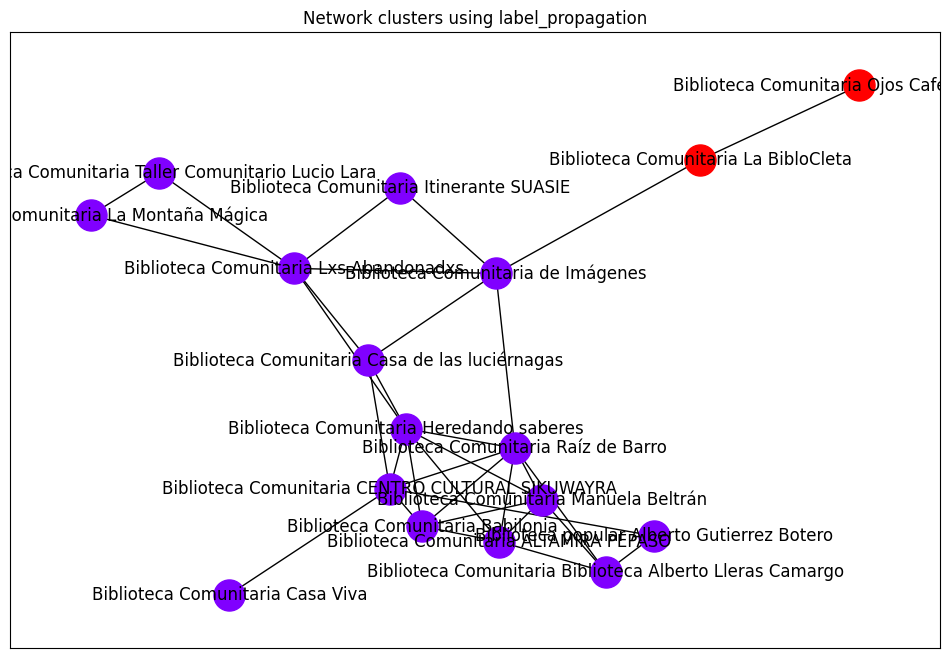

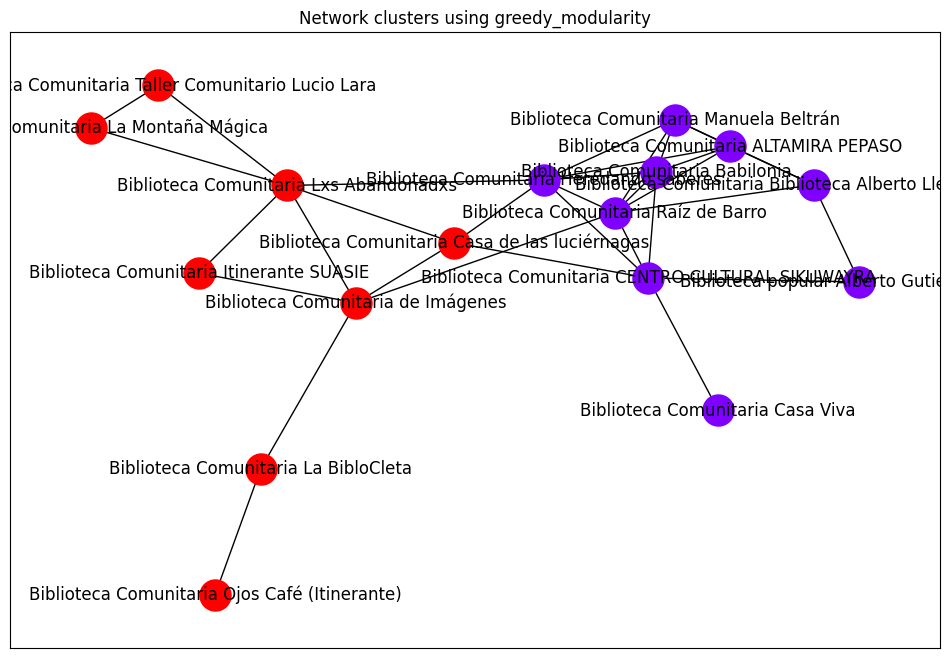

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def analyze_cluster_attributes(cluster, df):
    # Get subset of dataframe for cluster nodes
    cluster_df = df[df['BibliotecaNombre'].isin(cluster)]

    # Calculate statistics for numerical columns
    stats = cluster_df.describe()

    # Get mode for categorical columns
    categorical_stats = cluster_df.mode().iloc[0]

    return stats, categorical_stats


def draw_clustered_network(G, clusters, title):
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G)

    # Assign colors to clusters
    colors = plt.cm.rainbow(np.linspace(0, 1, len(clusters)))

    for cluster, color in zip(clusters, colors):
        nx.draw_networkx_nodes(G, pos,
                               nodelist=cluster,
                               node_color=[color],
                               node_size=500)

    nx.draw_networkx_edges(G, pos)
    nx.draw_networkx_labels(G, pos)
    plt.title(title)
    plt.show()

df = pd.read_csv("..\output\\results.csv")

# Analyze each clustering method
cluster_analysis = defaultdict(dict)
for method, clusters in clustering_results.items():
    for i, cluster in enumerate(clusters):
        stats, cat_stats = analyze_cluster_attributes(cluster, df)
        cluster_analysis[method][f'cluster_{i}'] = {
            'nodes': list(cluster),
            'size': len(cluster),
            'numerical_stats': stats,
            'categorical_stats': cat_stats
        }


# Visualize each clustering method
for method, clusters in clustering_results.items():
    draw_clustered_network(network, clusters, f'Network clusters using {method}')


In [41]:
PROMPT = """You are tasked with writing a short analysis in markdown for each category based on survey data collected from a cluster of libraries. Your goal is to provide concise, objective insights for each analysis category in markdown.

First, here are the analysis categories and their descriptions:

<analysis_categories>
**Categoría de análisis: Nivel de avance en la sistematización de servicios bibliotecarios**

1. **Coordenada:** Sistemas de clasificación
   - **Descripción:** Sistemas usados para la organización de las colecciones
   - **Recopilado por nosotros (Pregunta):** ¿Qué sistema de clasificación usa en la colección?

2. **Coordenada:** Nivel de detalle en la organización de la colección
   - **Descripción:** Nivel de organización de la colección en la biblioteca
   - **Recopilado por nosotros (Pregunta):** ¿Cómo se identifica la ubicación de los libros en la colección?

3. **Coordenada:** Tiempo que le toma hallar un libro
   - **Descripción:** Tiempo que toma encontrar un libro en la biblioteca
   - **Recopilado por nosotros (Pregunta):** ¿Cuánto tiempo en promedio tarda en encontrar un libro?

4. **Coordenada:** Sistema de registro de usuarios
   - **Descripción:** -
   - **Recopilado por nosotros (Pregunta):** ¿Cuenta con sistema de registro de usuarios?

5. **Coordenada:** Reglamento de servicios
   - **Descripción:** -
   - **Recopilado por nosotros (Pregunta):** ¿Existe un reglamento de servicios?

6. **Coordenada:** Sistematización en préstamo externo
   - **Descripción:** Nivel de sistematización en el proceso de préstamo de la biblioteca
   - **Recopilado por nosotros (Pregunta):** ¿Cómo se gestionan los préstamos externos de la colección?

---

**Categoría de análisis: Caracterización de la colección**

1. **Coordenada:** Tipos de colecciones
   - **Descripción:** Tipos de colección disponibles en la biblioteca
   - **Recopilado por nosotros (Pregunta):** -

2. **Coordenada:** Cantidad de material bibliográfico
   - **Descripción:** Número total de material bibliográfico en la colección
   - **Recopilado por nosotros (Pregunta):** -

3. **Coordenada:** Percepción del estado físico de la colección
   - **Descripción:** Percepción del estado de conservación de la colección
   - **Recopilado por nosotros (Pregunta):** ¿Cuál es su percepción general del estado de conservación de la colección?

4. **Coordenada:** Enfoques de las colecciones
   - **Descripción:** Calculada a partir de las respuestas múltiples de temas de las colecciones en las bibliotecas (si contesta un tema entonces es muy especializada, si contesta todos los temas no es especializada)
   - **Recopilado por nosotros (Pregunta):** ¿Las colecciones en su biblioteca tienen un enfoque en particular?

5. **Coordenada:** Actividades de mediación con la colección
   - **Descripción:** -
   - **Recopilado por nosotros (Pregunta):** ¿En cuáles actividades de mediación usas la colección?

6. **Coordenada:** Frecuencia actividades de mediación con la colección
   - **Descripción:** Frecuencia de mediación de lectura de las colecciones
   - **Recopilado por nosotros (Pregunta):** ¿Con qué frecuencia se usa la colección en actividades de mediación?

7. **Coordenada:** Colecciones especiales
   - **Descripción:** Presencia de colecciones especializadas o poco comunes
   - **Recopilado por nosotros (Pregunta):** ¿La biblioteca cuenta con colecciones de valor patrimonial?
</analysis_categories>

Now, here is the survey data collected from the libraries:

<survey_data>
{SURVEY_DATA}
</survey_data>

To complete this task, follow these steps:

1. Review the survey data carefully, focusing on the information relevant to each analysis category.

2. For each category, write a brief analysis (2-3 sentences) that summarizes the key findings or trends observed in the data.

3. Your analysis should be objective and based solely on the information provided in the survey data.

4. Present your analysis in the following format:

<analysis>
<category>[Category name]</category>
<summary>[Your 2-3 sentence analysis here]</summary>
</analysis>

5. Repeat this process for all categories listed.

6. Keep your language clear, concise, and professional.

7. If there is insufficient data to draw a conclusion for any category, state this clearly in your analysis.

8. Write using makrdown to bold important concepts and put titles

Remember to focus on providing insights that would be valuable for understanding the current state and potential areas for improvement in these libraries. Avoid making assumptions or drawing conclusions beyond what is directly supported by the data.

Present your complete analysis, covering all categories, in your response."""

In [42]:

# Analysis of Clusters
clustering_results
df_encuestas = pd.read_csv("../data/Formulario sobre coordenadas de análisis para el mapeo de colecciones en bibliotecas comunitarias de Bogotá (Respuestas) - Normalización Respuestas.csv")

# Explicación de los clusters
import openai

client = openai.OpenAI()


# Supongamos que ya tienes df_encuestas y df_categorias cargados

def construir_prompt(df_cluster):

    return PROMPT.format(SURVEY_DATA=df_cluster.to_string())


def analizar_cluster(cluster, df_surveys):
    # Filter the libraries in the cluster
    libraries = list(cluster)
    df_cluster = df_surveys[df_surveys['Nombre de la biblioteca comunitaria'].isin(libraries)]

    # Build the prompt
    prompt = construir_prompt(df_cluster)

    # Call the OpenAI API
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": "Eres un analista de datos especializado en bibliotecas comunitarias."},
            {"role": "user", "content": prompt}
        ],
        temperature=0.7,
    )

    # Extract the analysis
    analysis = response.choices[0].message.content.strip()
    return analysis


clusters = clustering_results
analisis = []
for algoritmo, lista_clusters in clusters.items():
    print(f"Análisis para el algoritmo: {algoritmo}\n")
    for idx, cluster in enumerate(lista_clusters):
        analisis.append(analizar_cluster(cluster, df_encuestas))
        print(f"Cluster {idx + 1}:\nProcesado\n")
    break

Análisis para el algoritmo: louvain

Cluster 1:
Procesado

Cluster 2:
Procesado

Cluster 3:
Procesado



In [45]:
from IPython.display import display, Markdown, Latex
string_analysis = ""
for i, text in enumerate(analisis):
    string_analysis += f"Cluster: {i+1}\n"
    string_analysis += f"Bibliotecas\n {lista_clusters[i]}\n"
    string_analysis += analisis[0] + "\n"

display(Markdown(string_analysis))

Cluster: 1
Bibliotecas
 {'Biblioteca Comunitaria Lxs Abandonadxs', 'Biblioteca Comunitaria Itinerante SUASIE', 'Biblioteca Comunitaria Ojos Café (Itinerante)', 'Biblioteca Comunitaria La BibloCleta', 'Biblioteca Comunitaria Taller Comunitario Lucio Lara', 'Biblioteca Comunitaria La Montaña Mágica', 'Biblioteca Comunitaria de Imágenes'}


```markdown
<analysis>
<category>Nivel de avance en la sistematización de servicios bibliotecarios</category>
<summary>Las bibliotecas presentan una **diversidad en el sistema de clasificación** utilizado, con algunas sin un sistema definido, lo que sugiere una falta de organización en la colección. El **tiempo promedio para encontrar un libro** varía entre 5 y 20 minutos, indicando que podría haber oportunidades para mejorar la eficiencia de búsqueda. Además, **ninguna de las bibliotecas cuenta con un sistema de registro de usuarios** o un reglamento de servicios formal, lo que podría limitar la gestión y el uso de los recursos disponibles.</summary>
</analysis>

<analysis>
<category>Caracterización de la colección</category>
<summary>Las bibliotecas presentan una **mezcla de tipos de colecciones**, con enfoques que varían desde literatura infantil hasta arte y derechos humanos. La **percepción del estado físico de la colección** es mayormente positiva, aunque se indica que algunos materiales requieren atención. Sin embargo, la **falta de un catálogo** en varias bibliotecas y la ausencia de actividades de mediación programadas limitan la accesibilidad y el uso efectivo de las colecciones.</summary>
</analysis>
```

Cluster: 2
Bibliotecas
 {'Biblioteca Comunitaria Casa de las luciérnagas', 'Biblioteca Comunitaria Casa Viva', 'Biblioteca popular Alberto Gutierrez Botero', 'Biblioteca Comunitaria CENTRO CULTURAL SIKUWAYRA'}


```markdown
<analysis>
<category>Nivel de avance en la sistematización de servicios bibliotecarios</category>
<summary>Las bibliotecas presentan una **diversidad en el sistema de clasificación** utilizado, con algunas sin un sistema definido, lo que sugiere una falta de organización en la colección. El **tiempo promedio para encontrar un libro** varía entre 5 y 20 minutos, indicando que podría haber oportunidades para mejorar la eficiencia de búsqueda. Además, **ninguna de las bibliotecas cuenta con un sistema de registro de usuarios** o un reglamento de servicios formal, lo que podría limitar la gestión y el uso de los recursos disponibles.</summary>
</analysis>

<analysis>
<category>Caracterización de la colección</category>
<summary>Las bibliotecas presentan una **mezcla de tipos de colecciones**, con enfoques que varían desde literatura infantil hasta arte y derechos humanos. La **percepción del estado físico de la colección** es mayormente positiva, aunque se indica que algunos materiales requieren atención. Sin embargo, la **falta de un catálogo** en varias bibliotecas y la ausencia de actividades de mediación programadas limitan la accesibilidad y el uso efectivo de las colecciones.</summary>
</analysis>
```

Cluster: 3
Bibliotecas
 {'Biblioteca Comunitaria Manuela Beltrán', 'Biblioteca Comunitaria Heredando saberes', 'Biblioteca Comunitaria ALTAMIRA PEPASO', 'Biblioteca Comunitaria Raíz de Barro', 'Biblioteca Comunitaria Babilonia', 'Biblioteca Comunitaria Biblioteca Alberto Lleras Camargo'}


```markdown
<analysis>
<category>Nivel de avance en la sistematización de servicios bibliotecarios</category>
<summary>Las bibliotecas presentan una **diversidad en el sistema de clasificación** utilizado, con algunas sin un sistema definido, lo que sugiere una falta de organización en la colección. El **tiempo promedio para encontrar un libro** varía entre 5 y 20 minutos, indicando que podría haber oportunidades para mejorar la eficiencia de búsqueda. Además, **ninguna de las bibliotecas cuenta con un sistema de registro de usuarios** o un reglamento de servicios formal, lo que podría limitar la gestión y el uso de los recursos disponibles.</summary>
</analysis>

<analysis>
<category>Caracterización de la colección</category>
<summary>Las bibliotecas presentan una **mezcla de tipos de colecciones**, con enfoques que varían desde literatura infantil hasta arte y derechos humanos. La **percepción del estado físico de la colección** es mayormente positiva, aunque se indica que algunos materiales requieren atención. Sin embargo, la **falta de un catálogo** en varias bibliotecas y la ausencia de actividades de mediación programadas limitan la accesibilidad y el uso efectivo de las colecciones.</summary>
</analysis>
```

In [50]:
response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": "Eres un poeta de las bibliotecas comunitarias"},
            {"role": "user", "content": "De acuerdo al analisis realizado vamos a darle un nombre a cada cluster de bibliotecas que las represente " + string_analysis}
        ],
        temperature=0.7,
    )

display(Markdown(response.choices[0].message.content.strip()))

Aquí tienes algunas sugerencias de nombres para cada cluster de bibliotecas, basadas en los análisis proporcionados:

### Cluster 1: "Bibliotecas en Proceso de Evolución"
Este nombre refleja la diversidad en la sistematización de servicios y la mezcla de colecciones, indicando que están en un camino de mejora y evolución.

### Cluster 2: "Bibliotecas de Luz y Creatividad"
Este nombre evoca la idea de iluminación y creatividad, destacando la variedad de enfoques en las colecciones, desde la literatura infantil hasta el arte y los derechos humanos.

### Cluster 3: "Bibliotecas de Saberes Compartidos"
Este nombre representa el espíritu de aprendizaje y colaboración que se observa en estas bibliotecas, que abarcan una amplia gama de temas y enfoques, promoviendo el intercambio de conocimientos.

Si deseas alguna modificación o tienes otra idea en mente, házmelo saber.